# CNN Implementation and Analysis on the CIFAR-100 Dataset
This notebook is intended to be run multiple times to explore all the preprocessing methods used for training. Two successive training functions should never be run. 

IMPORTANT: After one run of the notebook, please restart the kernel to ensure training starts from scratch.

## Data Loading

In [44]:
import tensorflow as tf

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

In [2]:
train_data.shape

(50000, 32, 32, 3)

We convert the labels from a [50000,1] shape in the case of training labels to [50000,20] where each entry of the new matrix is a one-hot vector. The one-hot vector is 1 for the class the image belongs to and 0 otherwise.

In [46]:
#One-hot encoding
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels) #[50000,1] -> [50000,20]
test_labels = to_categorical(test_labels)   #[10000,1] -> [50000,20]

## Model Creation and Compilation

We choose a simple CNN model consisting of 3 convolutional layers, 3 max pooling layers and ending in 2 dense layers. We use ReLU as the activation function for the layers except the final layer which uses a softmax function to output probabilites of the class the image belongs to. The padding attribute as 'same' ensures that the dimensions of the output stay the same size as the input.

In [7]:
#Model architecture similar to VGG2016

import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = keras.Sequential()
 
model.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'same', input_shape = (32,32,3))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
          
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(20, activation='softmax'))

Using TensorFlow backend.


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [9]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Data Preprocessing

We create a generator object that will yield image tuples that are normalised and augmented, the augmentations include rotation, x-shift, y-shift and horizontal flip. The generator object will be calibrated to use the featurewise mean and standard deviation of the training data. We perform analysis on three preprocessing techniques:
1. Data Augmentation
2. Data Augmentation with Normalisation
3. ZCA Whitening with Data Augmentation

This notebook uses workflow 1. If you want to check another preprocessing method please uncomment the corresponding code blocks.

In [40]:
#Scaling

train_data = train_data/255
test_data = test_data/255

Processing = ('2') #Change between 1,2 and 3 for the corressponding preprocessing application

#Preprocessing:Data Augmentation
if(Processing == '1'):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode = 'nearest')

#Preprocessing: Data Augmentation and Normalisation
elif(Processing == '2'):

    train_data = train_data - np.mean(train_data, axis = 0)
    train_data = train_data/np.std(train_data, axis = 0)

    test_data = test_data - np.mean(train_data, axis = 0)
    test_data = test_data/np.std(train_data, axis = 0)

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode = 'nearest')

#Preprocessing: ZCA Whitening and Data Augmentation
elif(Processing == '3'):

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode = 'nearest',
        zca_epsilon = 1e-6,
        zca_whitening = True)

    test_datagen = ImageDataGenerator(
        zca_epsilon = 1e-6,
        zca_whitening = True)
    
else: 
    print('Please use valid processing number')


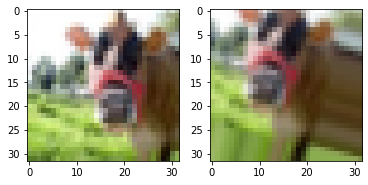

In [6]:
%matplotlib inline 

import matplotlib.pyplot as plt

gen = datagen.flow(train_data[0:1])
fig, ax = plt.subplots(1,2)
ax[1].imshow(next(gen).reshape((32,32,3)))
ax[0].imshow(train_data[0])

We choose the Adam optimiser for our network with a learning rate of 0.003 and categorical crossentropy as our loss function 

## Training Process

We first split the training set into training and validation sets to calculate the validation loss while training. Since, neural networks are very susceptible to overfitting we need a validation set to monitor this. We also flow dat through the generator object we calibrated earlier. We have also used a model checkpoint callback to save models while training at the end of every epoch so that we can evaluate using the model that has the highest validation accuracy. The total training time is approximately 90 minutes for Preprocessing method 1.

The training time for Preprocessing method 3 is approximately 5 hours, please check our results page in the report to get an idea of it's performance.

In [11]:
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

filepath = 'Models\CNN_{epoch}.hdf5' 

ckt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state = 0)

if(Processing != '3'):
    history = model.fit(datagen.flow(train_data, train_labels, batch_size = 32), 
                    steps_per_epoch = train_data.shape[0]/32, epochs=100,
                    validation_data = (val_data, val_labels),
                    callbacks = [ckt])
else:
    history = model.fit(train_datagen.flow(train_data, train_labels, batch_size = 32), 
                        steps_per_epoch = train_data.shape[0]/32, epochs=100,
                        validation_data = test_datagen.flow(val_data, val_labels),
                        callbacks = [ckt])

Epoch 1/100
1266/1265 [==============================] - 41s 32ms/step - loss: 2.5971 - accuracy: 0.1823 - val_loss: 2.3442 - val_accuracy: 0.2707

Epoch 00001: saving model to Models\CNN_1.hdf5
Epoch 2/100
   5/1265 [..............................] - ETA: 37s - loss: 2.2741 - accuracy: 0.2875

E:\Anaconda\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


1266/1265 [==============================] - 42s 34ms/step - loss: 2.3526 - accuracy: 0.2657 - val_loss: 2.2594 - val_accuracy: 0.3038

Epoch 00002: saving model to Models\CNN_2.hdf5
Epoch 3/100
1266/1265 [==============================] - 42s 33ms/step - loss: 2.2660 - accuracy: 0.2948 - val_loss: 2.1318 - val_accuracy: 0.3380

Epoch 00003: saving model to Models\CNN_3.hdf5
Epoch 4/100
1266/1265 [==============================] - 42s 34ms/step - loss: 2.2020 - accuracy: 0.3137 - val_loss: 2.1139 - val_accuracy: 0.3451

Epoch 00004: saving model to Models\CNN_4.hdf5
Epoch 5/100
1266/1265 [==============================] - 41s 33ms/step - loss: 2.1691 - accuracy: 0.3273 - val_loss: 2.0709 - val_accuracy: 0.3622

Epoch 00005: saving model to Models\CNN_5.hdf5
Epoch 6/100
1266/1265 [==============================] - 42s 33ms/step - loss: 2.1468 - accuracy: 0.3345 - val_loss: 2.0383 - val_accuracy: 0.3804

Epoch 00006: saving model to Models\CNN_6.hdf5
Epoch 7/100
1266/1265 [==============


Epoch 00043: saving model to Models\CNN_43.hdf5
Epoch 44/100
1266/1265 [==============================] - 44s 35ms/step - loss: 1.9173 - accuracy: 0.4064 - val_loss: 1.8562 - val_accuracy: 0.4300

Epoch 00044: saving model to Models\CNN_44.hdf5
Epoch 45/100
1266/1265 [==============================] - 44s 35ms/step - loss: 1.9165 - accuracy: 0.4048 - val_loss: 1.8607 - val_accuracy: 0.4356

Epoch 00045: saving model to Models\CNN_45.hdf5
Epoch 46/100
1266/1265 [==============================] - 45s 35ms/step - loss: 1.9122 - accuracy: 0.4049 - val_loss: 1.9028 - val_accuracy: 0.4113

Epoch 00046: saving model to Models\CNN_46.hdf5
Epoch 47/100
1266/1265 [==============================] - 44s 35ms/step - loss: 1.9035 - accuracy: 0.4070 - val_loss: 1.8631 - val_accuracy: 0.4233

Epoch 00047: saving model to Models\CNN_47.hdf5
Epoch 48/100
1266/1265 [==============================] - 44s 34ms/step - loss: 1.9099 - accuracy: 0.4057 - val_loss: 1.8945 - val_accuracy: 0.4213

Epoch 00048: s

1266/1265 [==============================] - 42s 33ms/step - loss: 1.8526 - accuracy: 0.4244 - val_loss: 1.8898 - val_accuracy: 0.4202

Epoch 00085: saving model to Models\CNN_85.hdf5
Epoch 86/100
1266/1265 [==============================] - 41s 32ms/step - loss: 1.8575 - accuracy: 0.4240 - val_loss: 1.8395 - val_accuracy: 0.4429

Epoch 00086: saving model to Models\CNN_86.hdf5
Epoch 87/100
1266/1265 [==============================] - 40s 32ms/step - loss: 1.8569 - accuracy: 0.4214 - val_loss: 1.8368 - val_accuracy: 0.4418

Epoch 00087: saving model to Models\CNN_87.hdf5
Epoch 88/100
1266/1265 [==============================] - 47s 37ms/step - loss: 1.8508 - accuracy: 0.4261 - val_loss: 1.8493 - val_accuracy: 0.4371

Epoch 00088: saving model to Models\CNN_88.hdf5
Epoch 89/100
1266/1265 [==============================] - 41s 32ms/step - loss: 1.8474 - accuracy: 0.4271 - val_loss: 1.8600 - val_accuracy: 0.4333

Epoch 00089: saving model to Models\CNN_89.hdf5
Epoch 90/100
1266/1265 [====

## Observations

We observe the training and loss trends with respect to the epochs and find the model that has the highest validation accuracy.

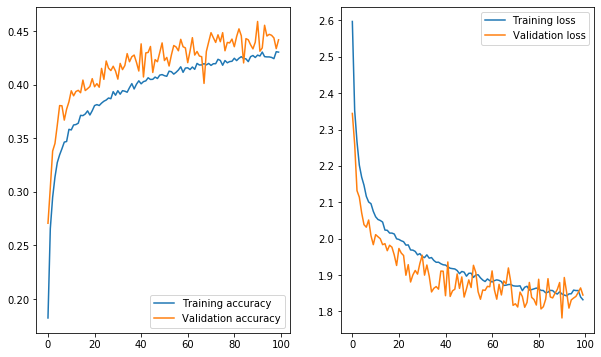

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

epochs = [i for i in range(100)]

fig, ax = plt.subplots(1,2, figsize = (10,6))

ax[0].plot(epochs, history.history['accuracy'], label = 'Training accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], label = 'Validation accuracy')
ax[0].legend()
#ax[0].xlabel('Epochs')
#ax[0].ylabel('Accuracy')

ax[1].plot(epochs, history.history['loss'], label = 'Training loss')
ax[1].plot(epochs, history.history['val_loss'], label = 'Validation loss')
ax[1].legend()
#ax[1].xlabel('Epochs')
#ax[1].ylabel('Accuracy')

    
plt.savefig('Observations\CNN_Preprocessing_'+Preprocessing+''.png')

In [50]:
#Choosing model with highest validation accuracy

import numpy as np
epoch = np.argmax(history.history['val_accuracy'])
model.load_weights(r'Models\CNN_'+str(epoch)+'.hdf5')

if (Processing!='3'):
    loss, accuracy = model.evaluate(test_data, test_labels)
else:
    loss, accuracy = model.evaluate(test_datagen.flow(test_data, test_labels))
    
print('Test accuracy = '+str(accuracy)+' Test Loss = '+str(loss))

10000/10000 [==============================] - 2s 181us/step
Test accuracy = 0.09480000287294388 Test Loss = 602.3631018554687


In [30]:
if(Processing!='3'):
    predictions = model.predict(test_data)
else:
    predictions = model.predict(test_datagen.flow(test_data))

In [31]:
predictions.shape

(10000, 20)

In [32]:
import numpy as np
predictions = np.argmax(predictions, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

In [33]:
correct = np.where(predictions == test_labels,1,0)
print(np.sum(correct)/len(test_labels))

0.4289


In [34]:
from sklearn import metrics

correct = np.where(predictions == test_labels,1,0)
print(metrics.classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.44      0.38      0.40       500
           1       0.45      0.34      0.39       500
           2       0.63      0.73      0.68       500
           3       0.39      0.49      0.44       500
           4       0.55      0.48      0.51       500
           5       0.34      0.33      0.33       500
           6       0.62      0.37      0.46       500
           7       0.42      0.45      0.43       500
           8       0.30      0.49      0.37       500
           9       0.60      0.53      0.56       500
          10       0.81      0.52      0.63       500
          11       0.47      0.24      0.32       500
          12       0.35      0.29      0.32       500
          13       0.23      0.12      0.16       500
          14       0.51      0.61      0.55       500
          15       0.22      0.34      0.27       500
          16       0.26      0.16      0.20       500
          17       0.76    

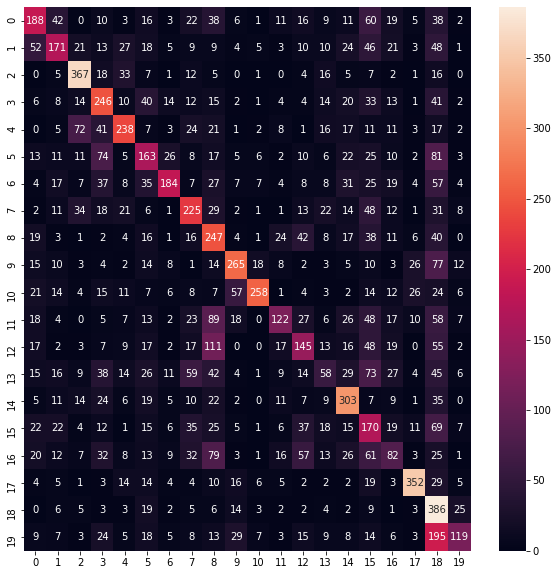

In [37]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
Preprocessing = '1'

cm = metrics.confusion_matrix(test_labels, predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,annot=True,fmt='g')
plt.savefig('Observations\CNN_Confusion_Matrix_Preprocessing_'+Preprocessing+'.png')
plt.show()